In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

# statsmodels for decomposition, ACF/PACF, tests
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.stattools import ccf

# scipy for signal / periodogram
from scipy.signal import periodogram

# small helper
def show(title):
    print("\n" + "="*80)
    print(title)
    print("-"*80)


In [2]:
datafile_path = "data.csv"  
df = pd.read_csv(datafile_path)

# Parse Date right away if not parsed
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d", errors='coerce')


In [3]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

In [4]:
# Ensure numeric dtypes and boolean casting
numeric_cols_all = ['Total_Amount','Unit_Price','Quantity','Discount_Amount',
                    'Session_Duration_Minutes','Pages_Viewed','Delivery_Time_Days','Customer_Rating','Age']

for col in numeric_cols_all:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert Is_Returning_Customer to boolean if present
if 'Is_Returning_Customer' in df.columns:
    if df['Is_Returning_Customer'].dtype == object:
        df['Is_Returning_Customer'] = df['Is_Returning_Customer'].map({'True': True, 'False': False, 'true': True, 'false': False})
    # If still not bool, coerce to bool-ish
    try:
        df['Is_Returning_Customer'] = df['Is_Returning_Customer'].astype('bool')
    except:
        pass

show("Dtypes after conversion")
display(df.dtypes)



Dtypes after conversion
--------------------------------------------------------------------------------


Order_ID                            object
Customer_ID                         object
Date                        datetime64[ns]
Age                                  int64
Gender                              object
City                                object
Product_Category                    object
Unit_Price                         float64
Quantity                             int64
Discount_Amount                    float64
Total_Amount                       float64
Payment_Method                      object
Device_Type                         object
Session_Duration_Minutes             int64
Pages_Viewed                         int64
Is_Returning_Customer                 bool
Delivery_Time_Days                   int64
Customer_Rating                      int64
Year                                 int32
Month                                int32
Day                                  int32
Weekday                              int32
WeekOfYear                           int64
dtype: obje

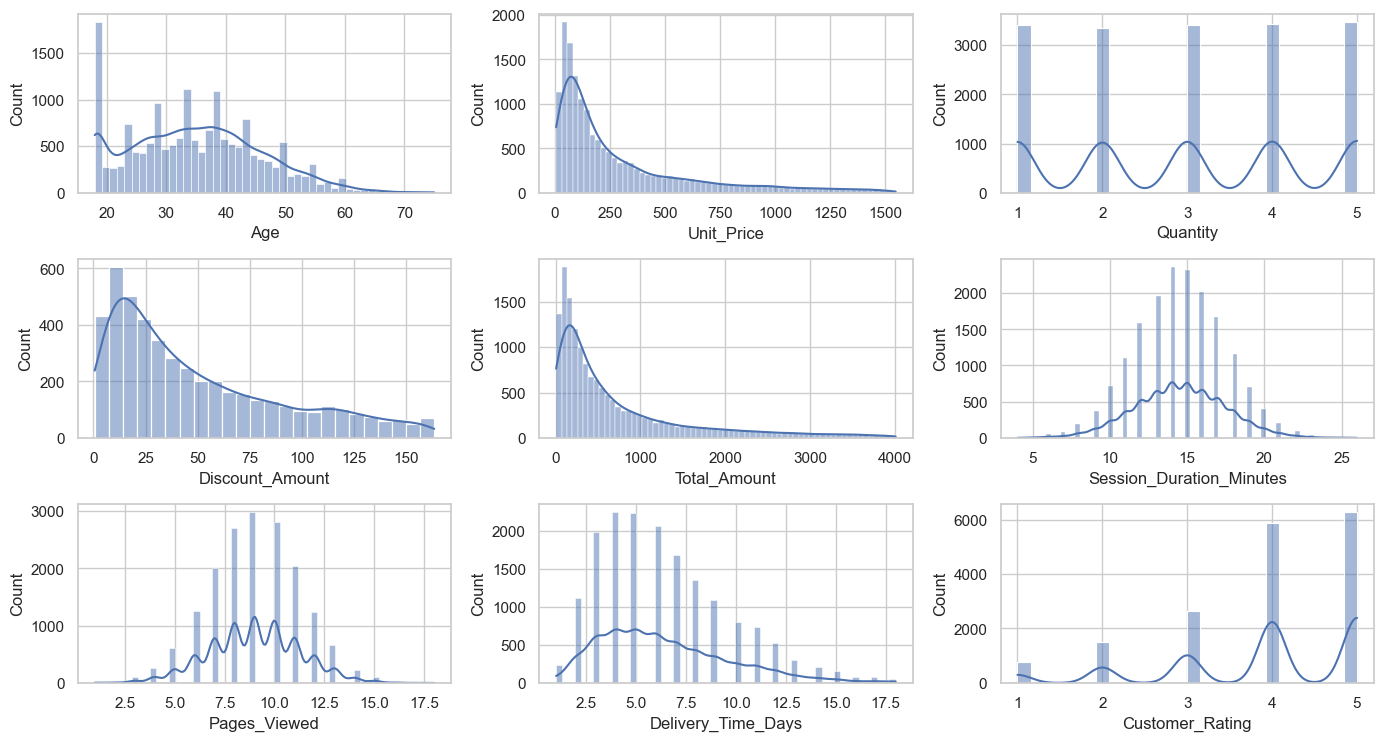

In [5]:
numeric_cols = ['Age','Unit_Price','Quantity','Discount_Amount','Total_Amount',
            'Session_Duration_Minutes','Pages_Viewed','Delivery_Time_Days','Customer_Rating']
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 2.5 * IQR
    return series[(series <= upper)]

def remove_outliers_discount(series):  
    # For Discount_Amount, we need to remove 0 values as they comprise a large portion of the dataset.
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 4 * IQR
    return series[(series != 0) & (series <= upper)]

plt.figure(figsize=(14, 12))
for i, col in enumerate(numeric_cols):
    if col != 'Discount_Amount':
        plt.subplot(5,3,i+1)
        filtered = remove_outliers(df[col])
        sns.histplot(filtered, kde=True)
    else:
        plt.subplot(5,3,i+1)
        filtered = remove_outliers_discount(df[col])
        sns.histplot(filtered, kde=True)
plt.tight_layout()

Skewness & Kurtosis (line-level):


,skew,kurt
Age,0.320455,-0.401339
Unit_Price,3.645695,17.603905
Quantity,-0.011929,-1.303566
Discount_Amount,8.640295,120.075599
Total_Amount,4.584842,30.380083
Session_Duration_Minutes,-0.008454,0.038253
Pages_Viewed,-0.033469,-0.012778
Delivery_Time_Days,1.132570,1.874366
Customer_Rating,-0.930286,0.088604


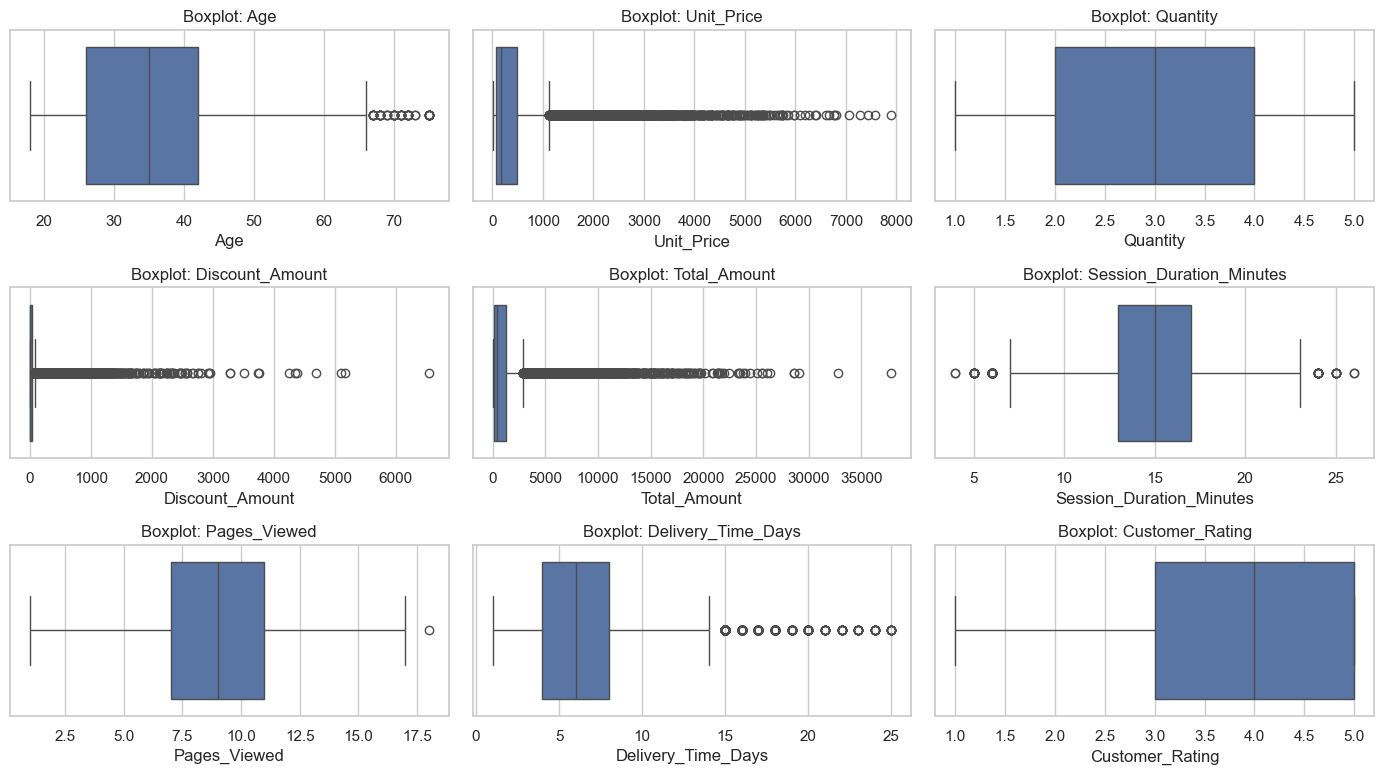

In [6]:
# Cell 7 — Boxplots & skew/kurtosis
line_num_cols = [c for c in numeric_cols if c in df.columns]

print("Skewness & Kurtosis (line-level):")
display(df[line_num_cols].agg(['skew','kurt']).T)

plt.figure(figsize=(14,10))
for i, col in enumerate(line_num_cols):
    plt.subplot(4,3,i+1)
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Boxplot: {col}')
plt.tight_layout()



Correlation matrix (discount > 0 only)
--------------------------------------------------------------------------------


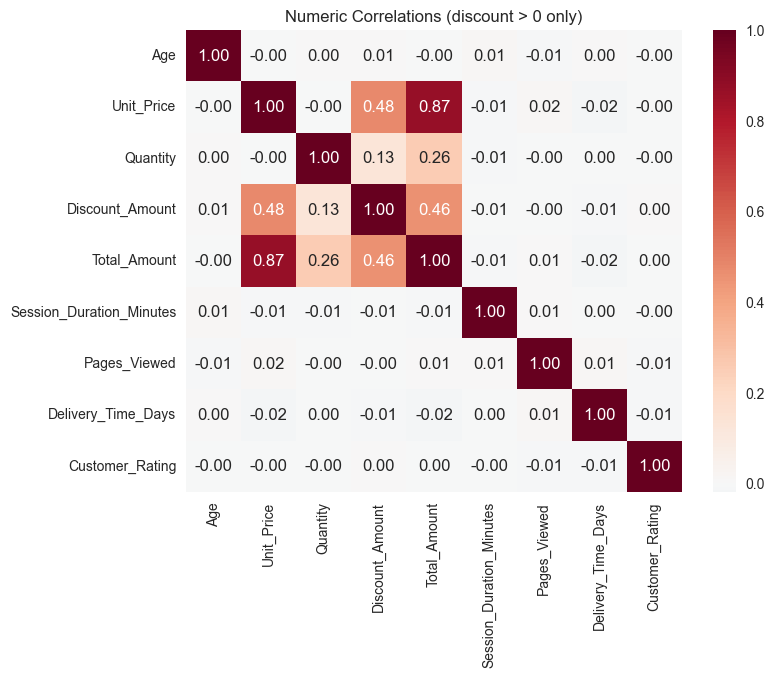

In [57]:
# Correlation heatmap (numeric), but discount_amount correlations use only rows with discount > 0

num_present = [c for c in line_num_cols if c in df.columns]

# If discount_amount is one of the columns of interest
if "discount_amount" in num_present:
    # Filter only rows where discount_amount > 0
    df_discount_pos = df[df["discount_amount"] > 0]

    # Compute correlation among numeric columns, but only using filtered rows
    corr = df_discount_pos[num_present].corr()
else:
    # Fallback: compute regular correlation
    corr = df[num_present].corr()

show('Correlation matrix (discount > 0 only)')
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title("Numeric Correlations (discount > 0 only)")
plt.show()


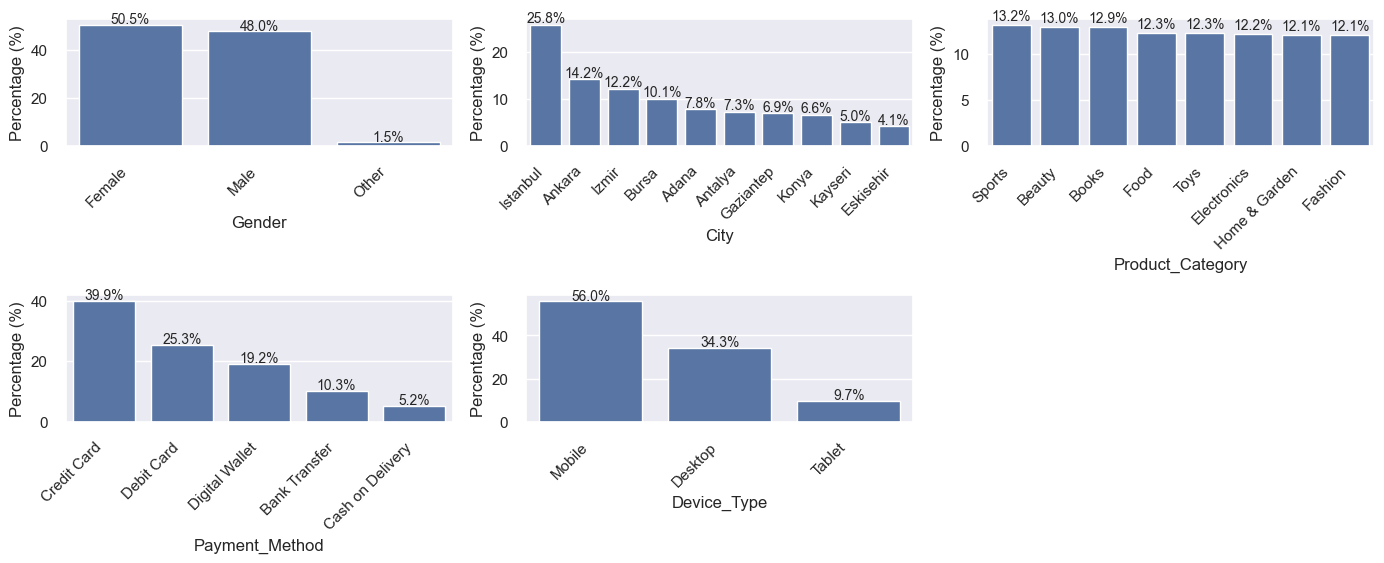

In [24]:
# Categorical columns' distributions

# Detect categorical columns (object or category dtype)
categorical_cols = ['Gender', 'City', 'Product_Category', 'Payment_Method', 'Device_Type']

# Plot settings
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.0)


plt.figure(figsize=(14,10))
for i, col in enumerate(categorical_cols):
    plt.subplot(4,3,i+1)
        # Compute proportions
    proportions = df[col].value_counts(normalize=True) * 100
    
    sns.barplot(
        x=proportions.index,
        y=proportions.values,
    )
    

    plt.ylabel("Percentage (%)")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    
    # Add labels on bars
    for i, val in enumerate(proportions.values):
        plt.text(i, val + 0.5, f"{val:.1f}%", ha='center', fontsize=10)
plt.tight_layout()

In [9]:
# Daily aggregates (each row is an order)
orders_daily = df.groupby('Date').agg(
    total_sales=('Total_Amount','sum'),
    n_orders=('Order_ID','nunique'),
    total_quantity=('Quantity','sum'),
    avg_unit_price=('Unit_Price','mean')
).sort_index()

orders_daily['AOV'] = orders_daily['total_sales'] / orders_daily['n_orders']
show('Orders daily (head)')
display(orders_daily.head())



Orders daily (head)
--------------------------------------------------------------------------------


,total_sales,n_orders,total_quantity,avg_unit_price,AOV
Date,,,,,
2023-01-01,33278.43,32,87,417.409063,1039.950938
2023-01-02,46967.58,35,106,413.747143,1341.930857
2023-01-03,61564.52,44,139,470.112727,1399.193636
2023-01-04,62412.49,35,107,663.639714,1783.214000
2023-01-05,43572.07,43,116,449.289302,1013.303953


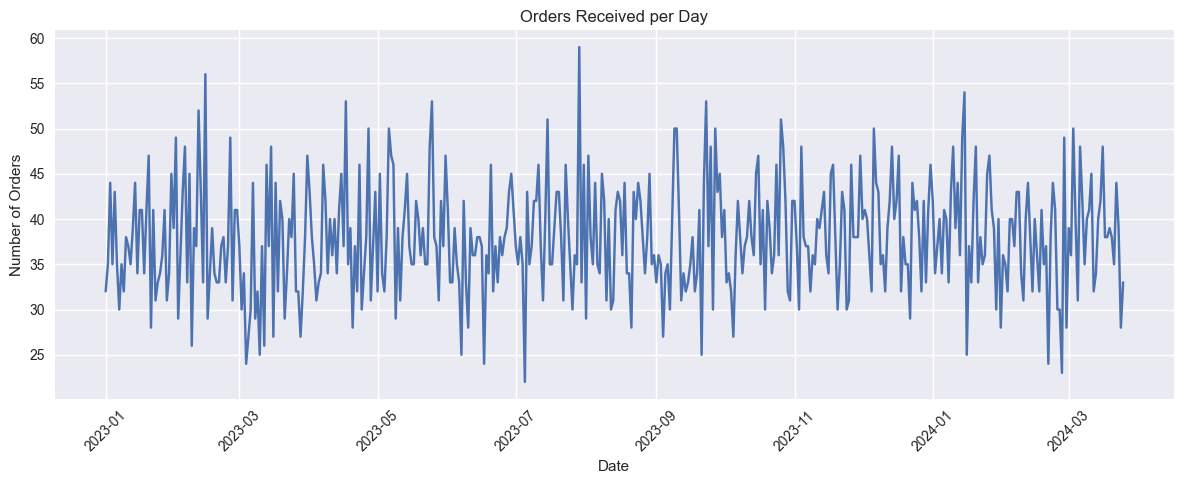

In [59]:
# Make sure order_date is datetime
df["order_date"] = pd.to_datetime(df["Date"])

# Count orders per day
orders_per_day = df.groupby(df["order_date"].dt.date).size()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(orders_per_day.index, orders_per_day.values)
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Orders Received per Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


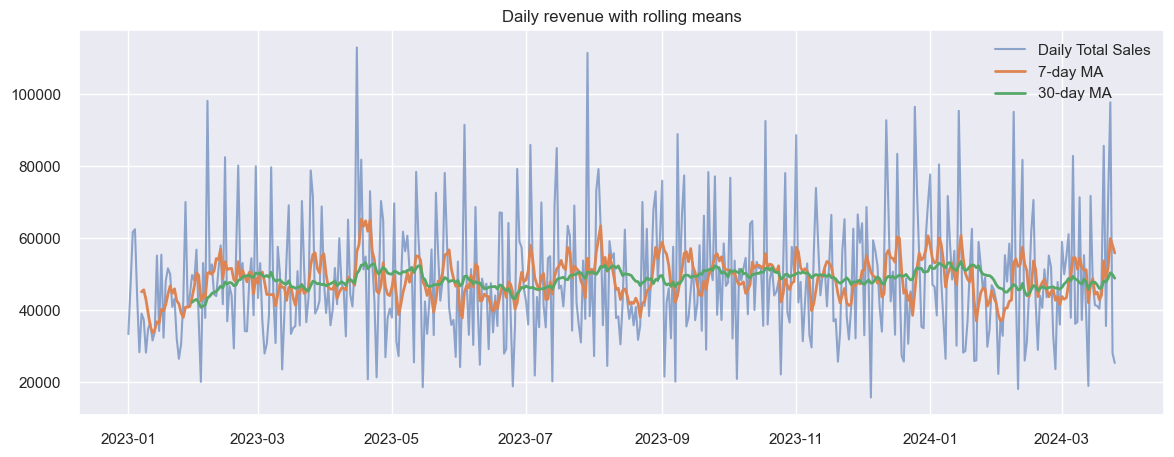

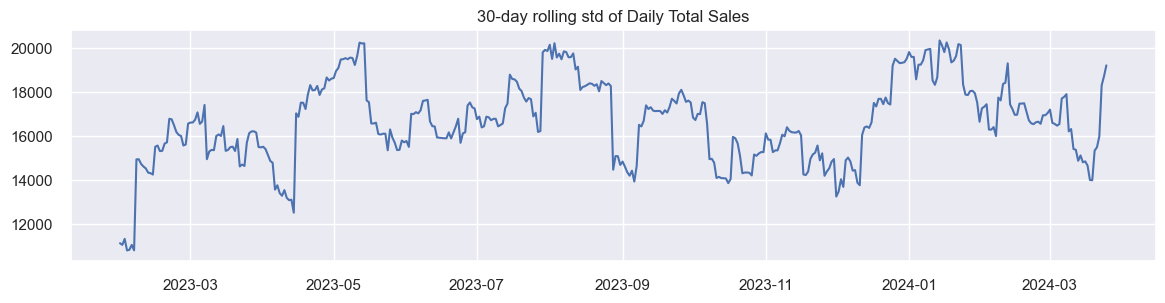

In [33]:
# Trend & rolling statistics (daily)
daily = orders_daily.copy()

plt.figure(figsize=(14,5))
plt.plot(daily['total_sales'], label='Daily Total Sales', alpha=0.6)
plt.plot(daily['total_sales'].rolling(7).mean(), label='7-day MA', linewidth=2)
plt.plot(daily['total_sales'].rolling(30).mean(), label='30-day MA', linewidth=2)
plt.legend()
plt.title('Daily revenue with rolling means')
plt.show()

plt.figure(figsize=(14,3))
plt.plot(daily['total_sales'].rolling(30).std())
plt.title('30-day rolling std of Daily Total Sales')
plt.show()


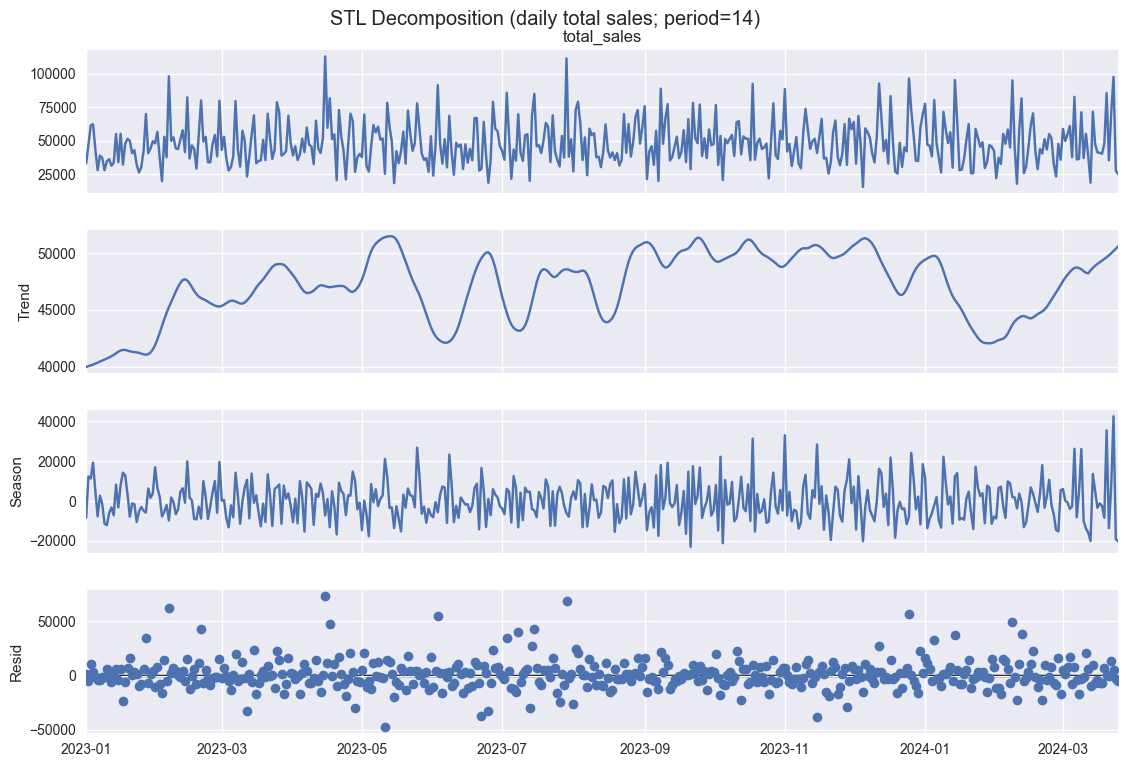

In [55]:
# STL decomposition (daily total sales)
series = daily['total_sales'].dropna()
period = 14  # weekly seasonality guess
stl = STL(series, period=period, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(12,8)
plt.suptitle(f'STL Decomposition (daily total sales; period={period})')
plt.show()


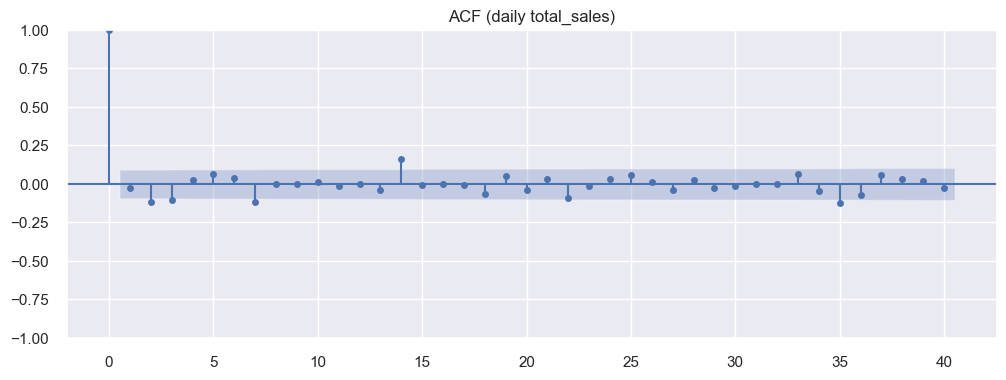

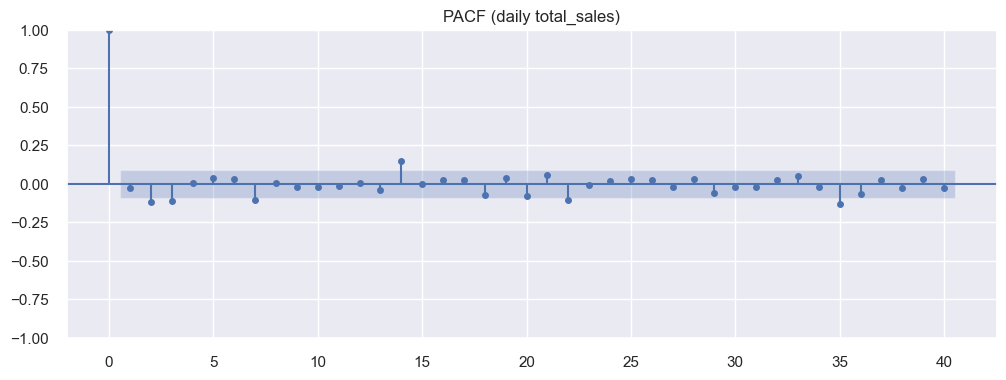

In [12]:
# Cell 13 — ACF & PACF on daily total_sales
series = daily['total_sales'].dropna()
plt.figure(figsize=(12,4))
plot_acf(series, lags=40, ax=plt.gca())
plt.title('ACF (daily total_sales)')
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(series, lags=40, ax=plt.gca(), method='ywm')
plt.title('PACF (daily total_sales)')
plt.show()


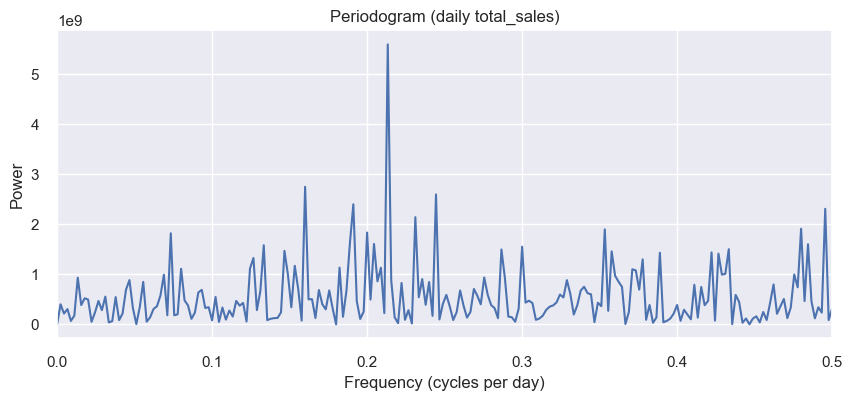

Top periods (days) by power:
freq=0.2133 -> period ≈ 4.7 days, power=5598464695.09
freq=0.1600 -> period ≈ 6.2 days, power=2751054482.65
freq=0.2444 -> period ≈ 4.1 days, power=2597852328.58
freq=0.1911 -> period ≈ 5.2 days, power=2400743403.73
freq=0.4956 -> period ≈ 2.0 days, power=2311156409.01
freq=0.2311 -> period ≈ 4.3 days, power=2142924413.68
freq=0.4800 -> period ≈ 2.1 days, power=1912746906.08
freq=0.3533 -> period ≈ 2.8 days, power=1900237103.57


In [13]:
# Periodogram (daily total_sales)
y = daily['total_sales'].fillna(0).values
fs = 1.0
f, Pxx = periodogram(y, fs=fs)
plt.figure(figsize=(10,4))
plt.plot(f, Pxx)
plt.xlim(0, 0.5)
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Power')
plt.title('Periodogram (daily total_sales)')
plt.show()

peak_idx = np.argsort(Pxx)[-8:][::-1]
print('Top periods (days) by power:')
for idx in peak_idx:
    if f[idx] > 1e-12:
        print(f'freq={f[idx]:.4f} -> period ≈ {1.0/f[idx]:.1f} days, power={Pxx[idx]:.2f}')



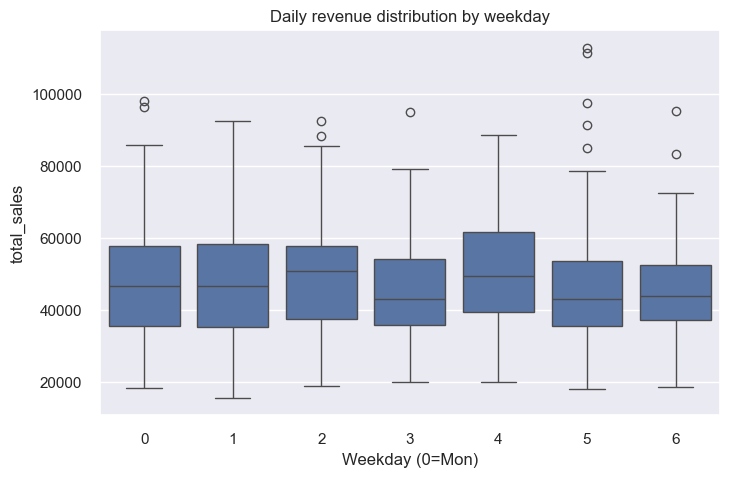

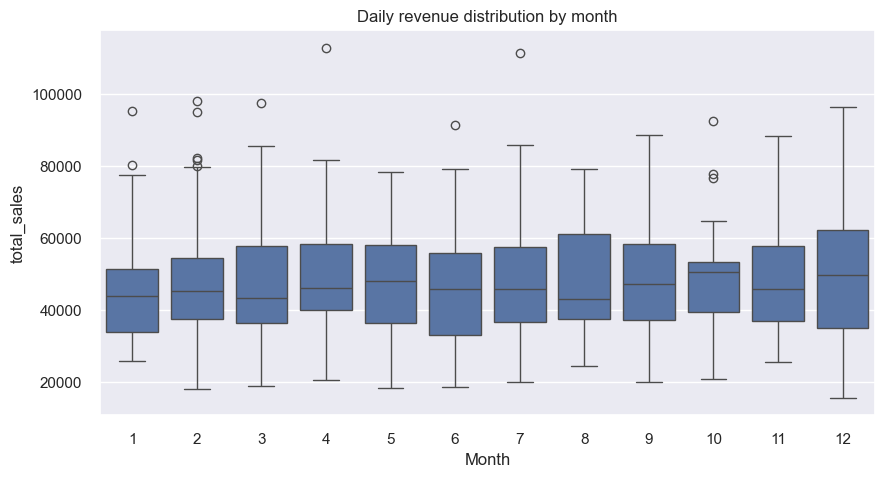

In [14]:
# Seasonal subseries: weekday & month boxplots
daily_df = daily.reset_index()
if not daily_df.empty:
    daily_df['Weekday'] = daily_df['Date'].dt.weekday
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Weekday', y='total_sales', data=daily_df)
    plt.xlabel('Weekday (0=Mon)')
    plt.title('Daily revenue distribution by weekday')
    plt.show()

    daily_df['Month'] = daily_df['Date'].dt.month
    plt.figure(figsize=(10,5))
    sns.boxplot(x='Month', y='total_sales', data=daily_df)
    plt.title('Daily revenue distribution by month')
    plt.show()
else:
    print("No daily data available.")


In [15]:
# Stationarity tests (ADF & KPSS)
from statsmodels.tsa.stattools import adfuller, kpss

adf_res = adfuller(series, autolag='AIC')
print('ADF test statistic: %.4f, p-value: %.4f' % (adf_res[0], adf_res[1]))

kpss_res = kpss(series, regression='c', nlags='auto')
print('KPSS test statistic: %.4f, p-value: %.4f' % (kpss_res[0], kpss_res[1]))

print("\nInterpretation: ADF H0 = unit root (non-stationary). KPSS H0 = stationary.")


ADF test statistic: -14.7412, p-value: 0.0000
KPSS test statistic: 0.2264, p-value: 0.1000

Interpretation: ADF H0 = unit root (non-stationary). KPSS H0 = stationary.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8256\3712161292.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, regression='c', nlags='auto')


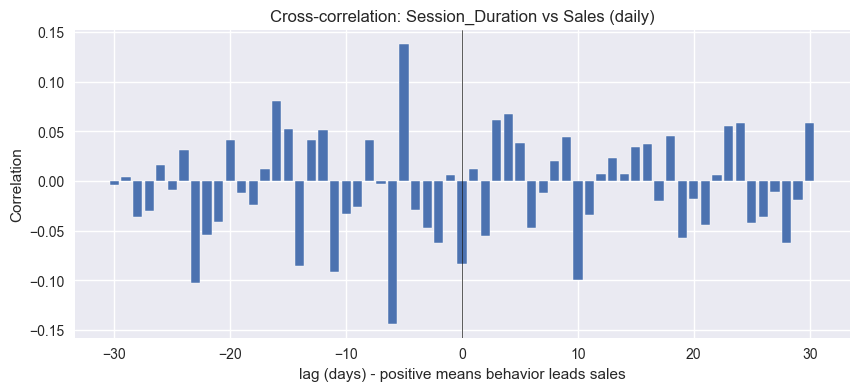

In [56]:
# Cross-correlation example: Session_Duration -> Sales (daily)

beh = df.groupby('Date')['Session_Duration_Minutes'].mean().reindex(daily.index).fillna(0)
sales = daily['total_sales'].fillna(0)

lags = 30
cc = [sales.corr(beh.shift(l)) for l in range(-lags, lags+1)]
lags_range = np.arange(-lags, lags+1)
plt.figure(figsize=(10,4))
plt.bar(lags_range, cc)
plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel('lag (days) - positive means behavior leads sales')
plt.ylabel('Correlation')
plt.title('Cross-correlation: Session_Duration vs Sales (daily)')
plt.show()




In [17]:
# Granger causality test (Session -> Sales)
if 'Session_Duration_Minutes' in df.columns and len(daily) > 3:
    beh = df.groupby('Date')['Session_Duration_Minutes'].mean().reindex(daily.index).fillna(0)
    sales = daily['total_sales'].fillna(0)
    gc_df = pd.DataFrame({'sales': sales, 'session': beh}).dropna()

    # difference if non-stationary
    if adfuller(gc_df['sales'])[1] > 0.05:
        gc_df['sales_d'] = gc_df['sales'].diff()
    else:
        gc_df['sales_d'] = gc_df['sales']

    if adfuller(gc_df['session'])[1] > 0.05:
        gc_df['session_d'] = gc_df['session'].diff()
    else:
        gc_df['session_d'] = gc_df['session']

    gc_df = gc_df[['sales_d','session_d']].dropna()
    maxlag = 7
    print('Running Granger causality tests (session -> sales) up to lag', maxlag)
    try:
        res = grangercausalitytests(gc_df[['sales_d','session_d']], maxlag=maxlag, verbose=False)
        for lag in range(1, maxlag+1):
            pval = res[lag][0]['ssr_ftest'][1]
            print(f'lag={lag:2d}, ssr F-test p-value = {pval:.4f}')
    except Exception as e:
        print('Granger causality test failed:', e)
else:
    print("Insufficient data or Session_Duration_Minutes missing for Granger test.")


Running Granger causality tests (session -> sales) up to lag 7
lag= 1, ssr F-test p-value = 0.8332
lag= 2, ssr F-test p-value = 0.3722
lag= 3, ssr F-test p-value = 0.4173
lag= 4, ssr F-test p-value = 0.3067
lag= 5, ssr F-test p-value = 0.3157
lag= 6, ssr F-test p-value = 0.3787
lag= 7, ssr F-test p-value = 0.6199


c:\Users\Administrator\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Top categories by revenue (line-level): ['Electronics', 'Home & Garden', 'Sports', 'Fashion', 'Toys', 'Beauty']


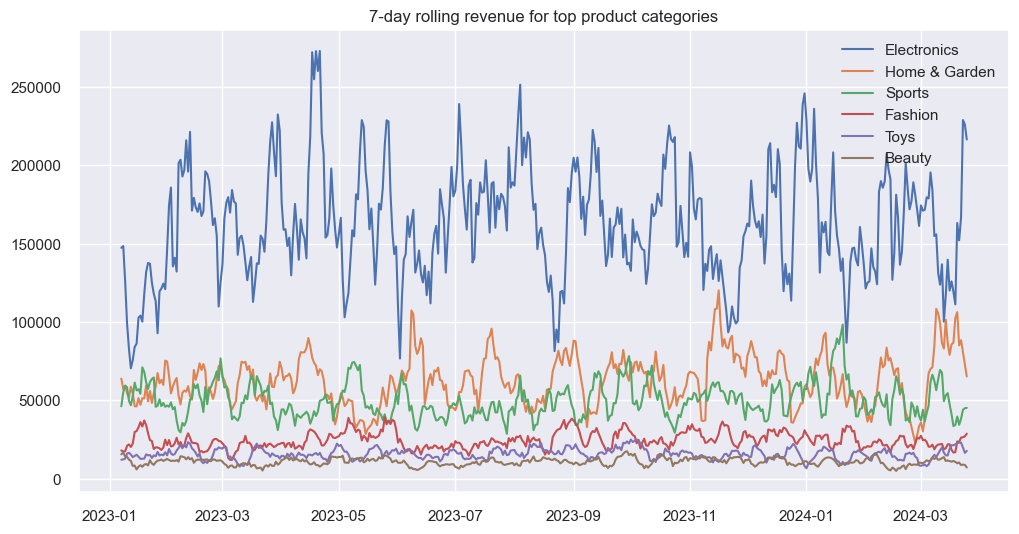


Top categories by order count
--------------------------------------------------------------------------------


Product_Category
Sports           2248
Beauty           2212
Books            2206
Food             2103
Toys             2090
Electronics      2074
Home & Garden    2060
Fashion          2056
Name: count, dtype: int64

In [18]:
# Category-level daily revenue (line-level)

cat_daily = df.groupby(['Date','Product_Category'])['Total_Amount'].sum().unstack(fill_value=0).sort_index()
top_cats = cat_daily.sum().sort_values(ascending=False).head(6).index.tolist()
print('Top categories by revenue (line-level):', top_cats)

plt.figure(figsize=(12,6))
for cat in top_cats:
    plt.plot(cat_daily.index, cat_daily[cat].rolling(7).sum(), label=cat)
plt.legend()
plt.title('7-day rolling revenue for top product categories')
plt.show()

# count number of orders containing each category (since each row is an order)
order_cat_counts = df['Product_Category'].value_counts()
show('Top categories by order count')
display(order_cat_counts.head(10))

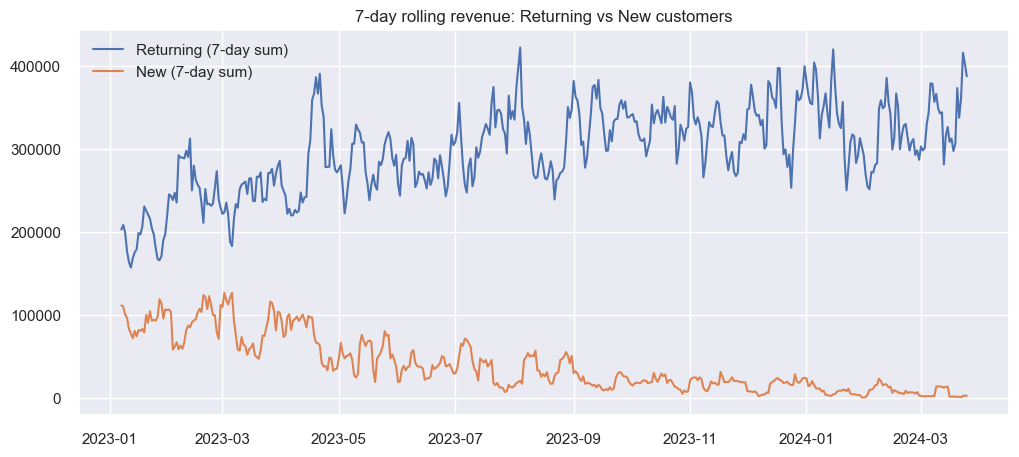


Average order value by returning flag
--------------------------------------------------------------------------------


Returning
False    1287.727428
True     1276.063599
Name: Total_Amount, dtype: float64

In [19]:
# Returning vs New customers (order-level)
if 'Is_Returning_Customer' in df.columns:
    df['Returning'] = df['Is_Returning_Customer'].astype(bool, errors='ignore')
    ret_daily = df.groupby(['Date','Returning'])['Total_Amount'].sum().unstack(fill_value=0).sort_index()

    plt.figure(figsize=(12,5))
    if True in ret_daily.columns:
        plt.plot(ret_daily.index, ret_daily[True].rolling(7).sum(), label='Returning (7-day sum)')
    if False in ret_daily.columns:
        plt.plot(ret_daily.index, ret_daily[False].rolling(7).sum(), label='New (7-day sum)')
    plt.legend()
    plt.title('7-day rolling revenue: Returning vs New customers')
    plt.show()

    aov_by_returning = df.groupby('Returning')['Total_Amount'].mean()
    show('Average order value by returning flag')
    display(aov_by_returning)
else:
    print("Is_Returning_Customer not in dataset.")


# Analysing the impact of Turkish and international holidays on sales amount

In [47]:
import holidays

# Cell A - Build Turkish holiday list for the analysis window (2023-01-01 to 2024-03-31)
start = pd.Timestamp("2023-01-01")
end   = pd.Timestamp("2024-03-31")

# Get Turkey holidays from python-holidays
tr_holidays = holidays.CountryHoliday('TR', years=[2023, 2024])

# Convert to DataFrame and filter by range
holiday_list = []
for d, name in sorted(tr_holidays.items()):
    dt = pd.Timestamp(d)
    if start <= dt <= end:
        holiday_list.append((dt, name))

hol_df = pd.DataFrame(holiday_list, columns=['date','name']).drop_duplicates().reset_index(drop=True)

# Add some international holidays if desired and justified
# (Valentine's Day, Christmas, New Year's Eve already in TR holidays maybe; adjust if needed)
international = [
    (pd.Timestamp('2023-02-14'), "Valentine's Day"),
    (pd.Timestamp('2024-02-14'), "Valentine's Day"),
    # If consider Christmas as well (already in TR as 25 Dec? usually not a major Turkish holiday)
    (pd.Timestamp('2023-12-25'), "Christmas"),
    (pd.Timestamp('2024-12-25'), "Christmas")
]
# Only add those within date range and not duplicate existing names
for dt, name in international:
    if start <= dt <= end and dt not in hol_df['date'].values:
        hol_df = pd.concat([hol_df, pd.DataFrame([[dt,name]], columns=['date','name'])], ignore_index=True)

hol_df = hol_df.sort_values('date').reset_index(drop=True)
print("Holidays found in range:")
display(hol_df)


Holidays found in range:


,date,name
0,2023-01-01,Yılbaşı
1,2023-02-14,Valentine's Day
2,2023-04-21,Ramazan Bayramı
3,2023-04-22,Ramazan Bayramı
4,2023-04-23,Ramazan Bayramı; Ulusal Egemenlik ve Çocuk Bay...
5,2023-05-01,Emek ve Dayanışma Günü
6,2023-05-19,"Atatürk'ü Anma, Gençlik ve Spor Bayramı"
7,2023-06-28,Kurban Bayramı
8,2023-06-29,Kurban Bayramı
9,2023-06-30,Kurban Bayramı


In [48]:
# Cell B - Compute sales lift for each holiday and classify importance
# We will use daily sales series `orders_daily` or fallback to df aggregation
if 'orders_daily' in globals():
    daily_sales = orders_daily.copy()
    # ensure index is datetime
    if not isinstance(daily_sales.index, pd.DatetimeIndex):
        daily_sales = daily_sales.set_index('Date')
    series = daily_sales['total_sales'] if 'total_sales' in daily_sales.columns else daily_sales['Total_Amount']
else:
    # fallback to df aggregation (each row = order)
    series = df.groupby('Date')['Total_Amount'].sum().sort_index()

series = series.sort_index()

# For each holiday compute:
# - holiday_sales = sales on holiday date
# - baseline = rolling median or mean for same weekday +/- window (look at 3 weeks centered)
def baseline_around(date, window_days=21):
    # baseline: exclude the day itself, use same weekday windows within +- window_days
    start = date - pd.Timedelta(days=window_days)
    end   = date + pd.Timedelta(days=window_days)
    window = series.reindex(pd.date_range(start, end)).dropna()
    # choose same weekday values excluding the holiday date
    same_wd = window[window.index.weekday == date.weekday()]
    same_wd = same_wd.drop(index=date, errors='ignore')
    if len(same_wd) >= 3:
        return float(same_wd.median())  # robust
    else:
        # fallback to window median excluding date
        w = window.drop(index=date, errors='ignore')
        return float(w.median()) if len(w) > 0 else np.nan

records = []
for _, row in hol_df.iterrows():
    d = row['date']
    name = row['name']
    holiday_sales = float(series.reindex([d]).fillna(0).values[0]) if d in series.index else float(0.0)
    baseline = baseline_around(d, window_days=21)
    if pd.isna(baseline) or baseline == 0:
        lift = np.nan
        pct = np.nan
    else:
        lift = holiday_sales - baseline
        pct = (lift / baseline) * 100.0
    records.append({'date': d, 'name': name, 'sales': holiday_sales, 'baseline': baseline, 'lift_abs': lift, 'lift_pct': pct})

holiday_effects = pd.DataFrame(records).sort_values('date').reset_index(drop=True)

# classify major/minor automatically: major if lift_pct > 25% or lift_abs > (2*baseline_std) — you can tune thresholds
# compute baseline std for each date (same logic)
def baseline_std(date, window_days=21):
    start = date - pd.Timedelta(days=window_days)
    end   = date + pd.Timedelta(days=window_days)
    window = series.reindex(pd.date_range(start, end)).dropna()
    same_wd = window[window.index.weekday == date.weekday()].drop(index=date, errors='ignore')
    if len(same_wd) >= 3:
        return float(same_wd.std())
    else:
        w = window.drop(index=date, errors='ignore')
        return float(w.std()) if len(w) > 0 else np.nan

holiday_effects['baseline_std'] = holiday_effects['date'].apply(lambda d: baseline_std(d, window_days=21))
# thresholds (tunable)
pct_threshold = 25.0  # >25% increase -> major
abs_threshold_factor = 2.0  # lift_abs > factor * baseline_std -> major

def classify(row):
    if pd.isna(row['lift_pct']):
        return 'unknown'
    if row['lift_pct'] >= pct_threshold:
        return 'major'
    if (not pd.isna(row['baseline_std'])) and (abs(row['lift_abs']) >= abs_threshold_factor * row['baseline_std']):
        return 'major'
    # also treat strong negative drops as notable (could be major negative)
    if row['lift_pct'] <= -25:
        return 'major-negative'
    return 'minor'

holiday_effects['importance'] = holiday_effects.apply(classify, axis=1)

display(holiday_effects[['date','name','sales','baseline','lift_abs','lift_pct','baseline_std','importance']])


,date,name,sales,baseline,lift_abs,lift_pct,baseline_std,importance
0,2023-01-01,Yılbaşı,33278.43,37302.160,-4023.730,-10.786855,4520.719720,minor
1,2023-02-14,Valentine's Day,82395.60,49763.150,32632.450,65.575531,20697.710867,major
2,2023-04-21,Ramazan Bayramı,72956.18,49996.580,22959.600,45.922341,16960.488899,major
3,2023-04-22,Ramazan Bayramı,53249.28,53953.990,-704.710,-1.306131,27925.485212,minor
4,2023-04-23,Ramazan Bayramı; Ulusal Egemenlik ve Çocuk Bay...,42640.12,47680.030,-5039.910,-10.570274,7210.061300,minor
5,2023-05-01,Emek ve Dayanışma Günü,37854.37,44116.340,-6261.970,-14.194219,24974.304480,minor
6,2023-05-19,"Atatürk'ü Anma, Gençlik ve Spor Bayramı",56795.11,46081.575,10713.535,23.249064,17448.686148,minor
7,2023-06-28,Kurban Bayramı,58999.13,29675.180,29323.950,98.816418,13505.870468,major
8,2023-06-29,Kurban Bayramı,57324.95,45509.615,11815.335,25.962283,18806.469484,major
9,2023-06-30,Kurban Bayramı,45988.38,51133.030,-5144.650,-10.061305,15658.484695,minor


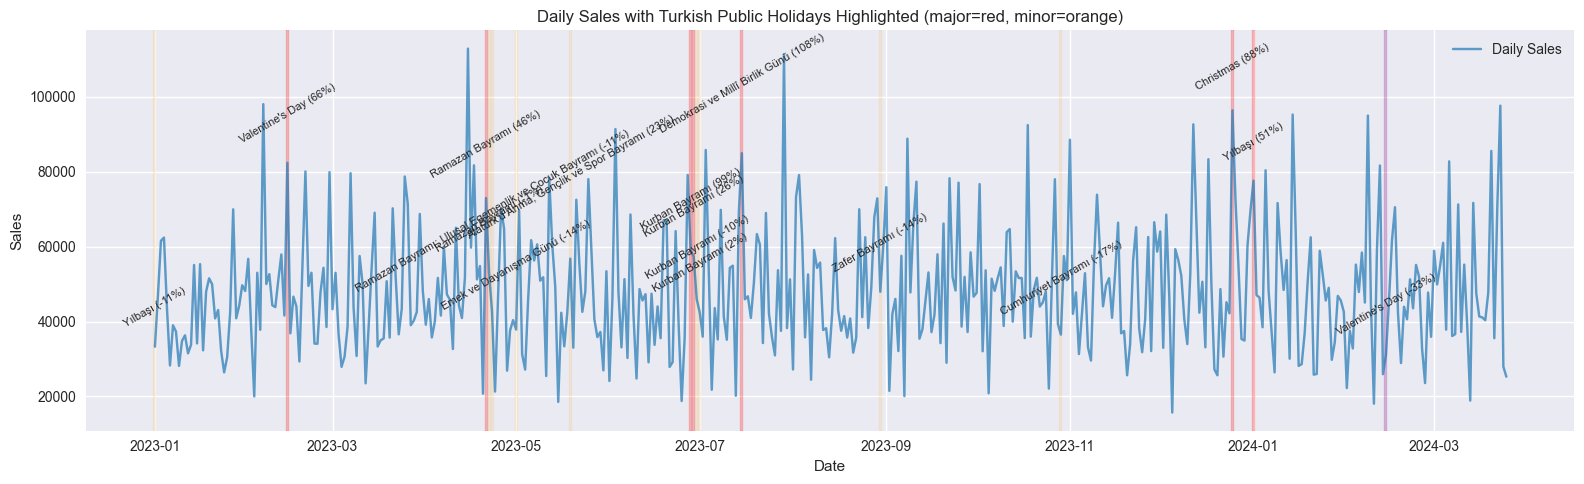

In [49]:
# Cell C - Plot daily sales and shade holidays (major/minor)
plt.figure(figsize=(16,5))
plt.plot(series.index, series.values, label='Daily Sales', color='tab:blue', alpha=0.7)

# Shade holidays: major darker, minor lighter; annotate name near point
ymin, ymax = plt.ylim()
for _, r in holiday_effects.iterrows():
    d = r['date']
    imp = r['importance']
    if pd.isna(r['sales']):
        continue
    if imp == 'major':
        color='red'; alpha=0.25
    elif imp == 'major-negative':
        color='purple'; alpha=0.25
    elif imp == 'minor':
        color='orange'; alpha=0.12
    else:
        color='grey'; alpha=0.08
    plt.axvspan(d - pd.Timedelta(hours=12), d + pd.Timedelta(hours=12), color=color, alpha=alpha)
    # annotate with short name and pct if available
    label = r['name']
    if not pd.isna(r['lift_pct']):
        label += f" ({r['lift_pct']:.0f}%)"
    plt.annotate(label, xy=(d, r['sales']), xytext=(d, r['sales'] + 0.05*(ymax-ymin)),
                 ha='center', fontsize=8, rotation=30)

plt.title('Daily Sales with Turkish Public Holidays Highlighted (major=red, minor=orange)')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()
